In [1]:
import numpy as np
import matplotlib.pyplot as plt
from read_roi import read_roi_zip
import ipywidgets as widgets
import untangle

import paleo
from mastodon_functions import xml_features, csv_features, ordering_tracks_all

# 2 - Spatial Analysis of cell tracks

In this notebook we will import the .csv files obtained from Mastodon to have a first look on how the cell tracks look like. Here we will play with the tags, subtags and observe the dividing cells. 

<a id='top'></a>
## Table of contents

[1] [Image Characteristics](#image): Check whether the uploaded files are indeed corresponding with the right images and imaging parameters.  

[2] [3D Spatial analysis](#3d): Here we show the 3 possible views (XY, XZ and YZ) of the coordinates of the cells.     

[3] [Project cells into LOI](#proj): Use the segmented tool from Fiji in order to obtain a segmented line which will be used to project the cells' coordinates and observe their dynamics over a certain reference frame. 

[4] [Code ir yourself!](#code): Until now all the code has been hidden and you only had to click a few boxes. In case you want to try coding yourself, we show you a some lines that will be useful to start preparing your own code. 

## Folder and data paths
In the next cell, you need to specify:
- ``path_xml``: Path and file name of the .xml file obtained from converting the data to HDF5/XML.
- ``path_csv``: Path and file name of the .csv file obtained from the tracks from Mastodon. You do not need to add the -edges or -vertices extension.
- ``path_hdf5``: Path and file name of the .h5 file obtained from converting the data to HDF5/XML.
- ``path_results``: Where to save the results like new tables or figures as PDFs.
- ``path_roi``: Path and name file of the RoiSet.zip generated from segmenting an LOI (used for the reference frame).
- ``path_kymograph``: If a Kymograph was previously computed using the Kymograph generator script, here you can add the path and file name of the Kymograph.py. 

In [2]:
position = 2

# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Position%d_20191213.xml'%position # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../Data/Position%d-20191213-v19'%position

# Path to .hs file generated when creating the xml/hdf5 
path_hdf5 =  '../Data/Position%d_20191213.h5'%position

# Where to save the results
path_result = '../Data/Results'

# Path to the .zip file which contains the ROIs or LOIs
path_roi = '../Data/RoiSet-Position%d.zip'%position

# Path to Kymograph.py generated with the Kymorgaph generator script 
path_kymograph = '../Data/Kymograph-Pos%d.npy'%position

## Image characteristics
<a id='image'></a>

Because we stored the data as an XML/HDF5, the .xml file contains all the metadata we need. We will now extract it in order to know pixel size, number of planes, image dimensions  and total number of timepoints. 

You only need to specify the temporal resolution in seconds that you used to acquire the data (``tr``). 

If you want to go back to the table of contents click [here](#top).

In [3]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


## Data organization: build the cell tracks

The function ``csv_features`` obtain all the features from each individual spot as a single unit. These spots are then rearranged according to their cell track and using the function ``ordering_tracks``. As a result, we get two new objects called ``spots`` and ``tracks``.

By pressing ``spots.`` + <kbd>TAB</kbd> or ``tracks.`` + <kbd>TAB</kbd>, a list will pop with all the different variables you can obtain from the spot object or the tracks obtject. 

In [4]:
# Function to obtain all the spots' information from the .csv file
#spots = csv_features(path_csv, path_xml)

# Order the time series according to each individual cell
tracks = ordering_tracks_all(path_csv, path_xml)

Arrange Cell Tracks: 100%|████████████████████| 128/128 [00:03<00:00, 35.63it/s]


## 3D Spatial Analysis
<a id='3d'></a>

Here you can visualize the spatial dynamics of the cells. From left to right, there are 3 plots: XY, XZ and YZ coordinates of the cells. You can visualize them over time, change the axes and fix them in order to observe how the cells move and re-arrange over time. Moreover, they can be color coded with one of the channels. The scatter plot can also be tuned by chaning the colormap, the size of the scatter spots and the transparency the data. 

If you want to go back to the table of contents click [here](#top).

In [5]:
%matplotlib widget

plt.style.use('mastodon_style.mplstyle')
paleo.Spatial3DAnalaysis(path_xml, path_csv, tr_min, tracks)

Spatial3DAnalaysis(children=(VBox(children=(Tab(children=(HBox(children=(VBox(children=(IntSlider(value=0, des…

## Spatial Analysis using LOI
<a id='image'></a>

An LOI (line of interest) can be used in order to get some spatial reference for the tracks. For example, here we segment the notochord (which is th natural midline of th emebryo) and we project the cells in the LOI. This way, we can observe how the cells move over time in the Anterior-Posterior axes. 

### How to create LOIs?

Here we read the LOIs created with Fiji's tool: [Segmented line](https://imagej.nih.gov/nih-image/manual/tools.html). You can chose to only draw lines in every few timepoitns and use an interpolation of ROI macro to interpolate lines between timepoints without segmented lines. Finaly, save the .roi files in a folder as a SetRoi.zip file. 

<div class="alert alert-block alert-warning">
    <b>WARNING:</b> When making the segmented lines, always start from the same reference position. For example, here we always start segmenting the posterior most part of the embryo. Therefore, our 0 position will be the posterior.
</div>

If you want to go back to the table of contents click [here](#top).

In [6]:
# Align using their temporal position

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan
y_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan
z_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan

# For each track 
for i in range(tracks.n_tracks_divs):
    
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(tracks.spots_features['Frames'][i]):
        tracks_save[i,val] = tracks.spots_features['Mean1'][i][j]
        x_save[i,val] = tracks.spots_features['X'][i][j]
        y_save[i,val] = tracks.spots_features['Y'][i][j]
        z_save[i,val] = tracks.spots_features['Z'][i][j]

### Remove registration 

If the movie was time-registered for tracking, the first step is to remove the registration to go back to the original coordinate system so that we can project these cells into the max projection.

In [7]:
obj = untangle.parse(path_xml)

x_save_r = []
y_save_r = []
z_save_r = []
    
time_points = fts.n_frames

for j in range(tracks.n_tracks_divs):
    
    aux_x = []
    aux_y = []
    aux_z = []
    
    for i in range(0,(time_points-1)*fts.channels,fts.channels):
        
        # XYZ coordinates from mastodon
        xyz_coord = np.array([x_save[j][int(i/2)],y_save[j][int(i/2)],z_save[j][int(i/2)]]).reshape(-1,1)
    
        # Registration from .xml
        registration = np.array(obj.SpimData.ViewRegistrations.ViewRegistration[i].ViewTransform[0].affine.cdata.split(),dtype=float).reshape(3,4)
        
        # Rotation matrix
        R = registration[:,:3] 
        
        # Inverse of rotation matrix
        R_inv = np.linalg.inv(R)
        
        # Translation matrix
        T = registration[:,-1].reshape(-1,1)
        
        final = R_inv@(xyz_coord-T)
        
        # Save xyz de-registered coordinates
        aux_x.append(final[0][0])
        aux_y.append(final[1][0])
        aux_z.append(final[2][0])

    x_save_r.append(aux_x)
    y_save_r.append(aux_y)
    z_save_r.append(aux_z)

## LOI (line of interest) as new reference frame

In the following Jupyter cells, we will use the LOIs we obtained from Fiji using the [segmented line](https://imagej.nih.gov/ij/docs/tools.html) and the [ROI manager](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:ROI-Manager...) to save all the lines we draw to segment a region of interest in the tissue. The idea is to use this line as our new coordinate system by transforming the 3D data into a 1D line to study one specific axis. 

For this example, we use an LOI following the Notochord (the midline of the embryo) in the XY plane. In the picture below you can observe a max projection of a timepoint of the movie and in yellow the segmented line. You can use the [LOI interpolator](https://imagej.nih.gov/ij/docs/guide/146-10.html). 

<img src="../Images-Notebook/LOI-Notochord.png" width="300" align="center">

If you want to go back to the table of contents click [here](#top).

### Upload the .zip files with the generated ROIs

In [8]:
# Read all the ROIs

rois = read_roi_zip(path_roi)

# Number of points in each segmented notochord line
notochord_points = 32

# Name of ROIs per time point
name_rois = list(rois.keys())

time_points = len(rois)

# Initialize where to save the coordinates
x_coords_not = np.zeros((time_points, notochord_points))
y_coords_not = np.zeros((time_points, notochord_points))

for j in range(len(rois)):

    # To know in which frame the analysis happened
    frame = rois[name_rois[j]]['position']-1#['frame']-1

    x_coords_not[frame,:] = rois[name_rois[j]]['x']
    y_coords_not[frame,:] = rois[name_rois[j]]['y']

### Equidistant points: to increase spatial resolution

Since when generating the LOI you must have made few points for simplicity, here we increment the number of points so that the line is more continuous. This will be helpful for when we project the cells later. 

In [9]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
n_points = 10 # Number of points to add 

for i in range(time_points):
    
    # Initial number of points from fiji
    x = x_coords_not[i].astype(int)
    y = y_coords_not[i].astype(int)
    
    x_aux = []
    y_aux = []
    
    for j in range(notochord_points-1):
        aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))
        
        # For each of the inserted points
        for k in range(len(aux)-1):
            x_aux.append(aux[k][0])
            y_aux.append(aux[k][1])
            
    x_not_equidist.append(x_aux)
    y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

Number of timepoints: 300
Number of points per timepoint: 310


### Cells plotted within the LOI

We now visualize the cells on top of the segmented LOI. We can choose two tiempoints to do so: ``tp1`` and ``tp2``. 
The black line represents the segmented LOI and the red spot is the reference point. We always use the first point drawn as our reference point, which is why it is very important to be consisten on where we start to draw the LOI.

In [10]:
tp1 = 10
tp2 = 150

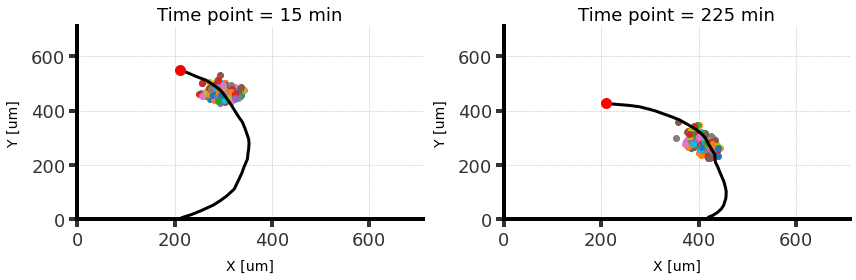

In [11]:
%matplotlib inline
plt.figure(figsize=[12,4])
plt.subplot(121)
tp = tp1
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(tracks.n_tracks_divs):
    plt.scatter(x_save_r[j][tp],y_save_r[j][tp])

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])


plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.subplot(122)
tp = tp2
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(tracks.n_tracks_divs):
    plt.scatter(x_save_r[j][tp],y_save_r[j][tp])

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])

plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.tight_layout()
plt.show()

### Project cells into the ROI

We can now project the cells into the LOI in order to have a new reference frame which in this case will the the plane in which the segmented line was created.

In [12]:
# Distances

distances = []
n_cells = tracks.n_tracks_divs
time_points = fts.n_frames

for i in range(n_cells):
    
    aux_time = []
    
    for k in range(time_points-1):
    
        # Let us work in pixel values 
        x_cell = x_save_r[i][k]/fts.x_pixel
        y_cell = y_save_r[i][k]/fts.y_pixel
        
        if np.isnan(x_cell)==False or np.isnan(y_cell)==False:

            x_roi = np.array(x_not_equidist[k])
            y_roi = np.array(y_not_equidist[k])

            # Index to closest point in notochord 
            ind = np.argmin(np.sqrt((x_roi-x_cell)**2+(y_roi-y_cell)**2))

            aux_dist = []

            for j in range(1,len(x_roi)):
                aux_dist.append(np.sqrt((x_roi[j]-x_roi[j-1])**2+(y_roi[j]-y_roi[j-1])**2))

            aux_time.append(np.cumsum(aux_dist)[ind])
        
        else:
            aux_time.append(np.nan)
        
    # Save the distances for each cell
    distances.append(aux_time)

### Obtian binning units from cells

In [13]:
max_dist = 1800
n_points = 100

# Save binned distances and intensities for each cell
distances_bin = []

for k in range(n_cells):
    
    # Perform the binning
    aux = (np.array(distances[k]))*n_points/max_dist
    
    # Save the distances
    distances_bin.append(aux)

## How the cells behave with respect the tissue level pattern?

Using the Kymograph notebook you were able to generate the tissue level dynamics over space and time. In the next Jupyter cells, wew ill upload the kymograph and observe how the cells behave over time and space. This way, we can have a comparison between the single cells and the tissue level. 

In [14]:
%matplotlib inline
kymograph = np.load(path_kymograph)

# timepoints
time_points = np.shape(kymograph)[0]
max_dist = 1800
n_points = 100

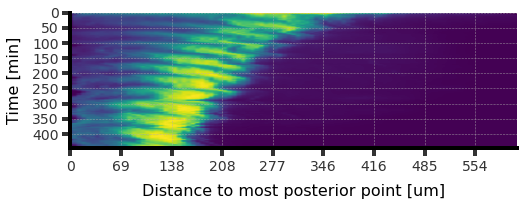

In [15]:
# Normalize the values
kymograph_2 = kymograph/np.max(kymograph)

fig = plt.figure(figsize=[8,10])
plt.imshow(kymograph_2, aspect=0.1)
plt.xlabel('Distance to most posterior point [um]', fontsize=16)
plt.ylabel('Time [min]', fontsize=16)

plt.yticks(np.linspace(0,time_points,10),map(int,np.linspace(0,time_points,10)*tr/60), fontsize=14)
plt.xticks(np.linspace(0,n_points,10),map(int,np.linspace(0,max_dist,10)*fts.x_pixel), fontsize=14)
plt.xlim([0,n_points-2])
plt.ylim([0,time_points-2])
plt.gca().invert_yaxis()

### How does the intensity compare from the tissue level to the single cells?

For this, you can choose which cell do you want to observe compared to the wave generated during that space and time poisitions. 

In [16]:
cells = [10]

In [17]:
intensities = []
for j in range(n_cells):
    aux_int = []

    for i in range(time_points-2):
        dist = distances_bin[j][i]

        # If there is no nan, then we obtain the kymograph values
        if np.isnan(dist)==False:
            x = int(dist)
            y = i
            aux_int.append(kymograph_2[y,x])
        else:
            aux_int.append(np.nan)
            
    intensities.append(aux_int)

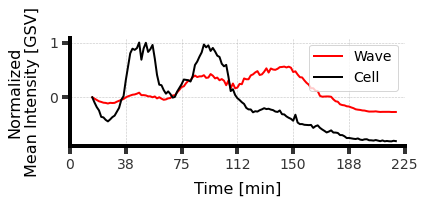

In [18]:
#cell = 6
plt.figure(figsize=[6,2])

count = 0

for i in cells: 
    aux = intensities[i]
    aux = np.array(aux)

    
    if count == 0:
        # Remove first value to start from 0
        init_vals = aux-aux[np.isfinite(aux)][0]
        plt.plot(init_vals, color='red', linewidth=2, label='Wave')
        
        # Normalize intensity values
        init_vals = tracks_save[i]-np.mean(tracks_save[i][np.isfinite(tracks_save[i])][0])
        norm_vals = init_vals/np.nanmax(init_vals)
        plt.plot(norm_vals, color='black', linewidth=2, label='Cell')

    else:
        # Remove first value to start from 0
        init_vals = aux-aux[np.isfinite(aux)][0]
        plt.plot(init_vals, color='red', linewidth=2)
        
        # Normalize intensity values
        init_vals = tracks_save[i]-np.mean(tracks_save[i][np.isfinite(tracks_save[i])][0])
        norm_vals = init_vals/np.nanmax(init_vals)
        plt.plot(norm_vals, color='black', linewidth=2)
        
    count +=1
        
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized\nMean Intensity [GSV]', fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.xlim([0,150])

plt.show()

## Code it your self!
<a id='code'></a>

If you want to go back to the table of contents click [here](#top).